# January 30th: Cleaning up the code, creating function files. Yeah.

In [7]:
from astropy.table import Table, vstack, Column, hstack,unique
from astropy.io import fits
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import NullFormatter
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
import astropy.units as u
import matplotlib.gridspec as gridspec
from scipy.stats import norm
from grizli import utils
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import eazy.utils
from astropy.cosmology import Planck15
from astropy.visualization import LogStretch
import scipy.ndimage as nd
import math
import time
import statmorph
from collections import OrderedDict

#### Generate script that downloads photcats for all fields - MOVED TO get_phot_tabs.py

#### Create complete photometric table and save (so you don't have to run it again) --> look at old code to get this.
photcat.write('../complete/photcats/other_full_phot.fits',overwrite=True)

#### To generate complete table including photometric info, refer to --> generate_master_table.py
- phot.write('../final_data/phot.fits',overwrite = True)
- and then:
- cats.write('../full_with_phot.fits',overwrite=True)

In [8]:
# In generate_master_table.py you created "full_with_phot.fits". 
# This is the starting table. Now, make some quality cuts

cats = utils.GTable.read('../full_with_phot.fits')

grism_clip = (cats['chinu']<2) & (np.isfinite(np.array(cats['chinu'])))
grism_clip &= (cats['bic_diff']>10) & (np.isfinite(np.array(cats['bic_diff'])))
grism_clip &= (cats['zwidth1']<0.1) & (np.isfinite(np.array(cats['zwidth1'])))
grism_clip &= np.isfinite(np.array(cats['redshift'])) &(cats['redshift']>0.7) & (cats['redshift'] <1.5)

print('initial sample: ',len(cats))
print('after grism quality cuts: ',grism_clip.sum())

# Here remove any objects that have more than 10% of pixels masked
sel = np.isfinite(np.array(cats['f140w_mask_aper_1']))
npix_aper1 = round(np.max(cats['f140w_mask_aper_1'][sel]))

# This was a pain... had to convert to numpy array or else it would mask funny
frac_masked_f140 = np.array(cats['f140w_mask_aper_1']/npix_aper1)
frac_masked_f160 = np.array(cats['f160w_mask_aper_1']/npix_aper1)

grism_clip &= (np.isfinite(frac_masked_f140) | np.isfinite(frac_masked_f160))
print('after removing nan values for f140/f160: ',grism_clip.sum())

grism_clip &= ((frac_masked_f140 < 0.1) | (frac_masked_f160 < 0.1))
print('after removing fraction masked < 0.1: ',grism_clip.sum())

grism = cats[grism_clip]
grism['color']  = grism['mag_wfc3,ir,f125w']-grism['mag_wfc3,ir,f160w']

#grism.write('../final_data/grism.fits')

initial sample:  292707
after grism quality cuts:  30120
after removing nan values for f140/f160:  30050
after removing fraction masked < 0.1:  29047


#### To generate/compile 3D-HST photometric table --> generate_3dhst_phot_table.py
- cat_3dhst_clean.write('../final_data/cat_3dhst_clean.fits')

In [9]:
# cat_3dhst_clean is the 3D-HST phot/zout/fout table
# grism is the cleaned grizli table
# Here I match the two tables together.

cat_3dhst_clean = utils.GTable.read('../final_data/cat_3dhst_clean.fits')
grism = utils.GTable.read('../final_data/grism.fits')

# First, match 3dhst catalog to available objects in my catalog

idx, dr = cat_3dhst_clean.match_to_catalog_sky(grism)
idx = idx[dr.value<0.6]
grism_matched23dhst = grism[(dr.value<0.6)]
hst_matched2grism = cat_3dhst_clean[idx]
len(hst_matched2grism)

2662

## Find photometry offsets between 3dhst and grism

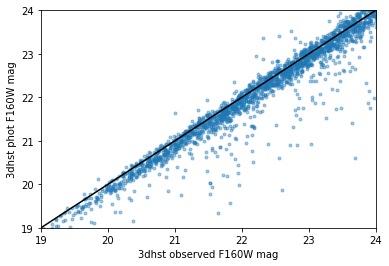

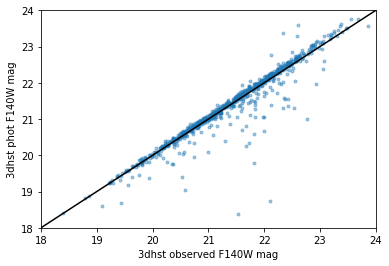

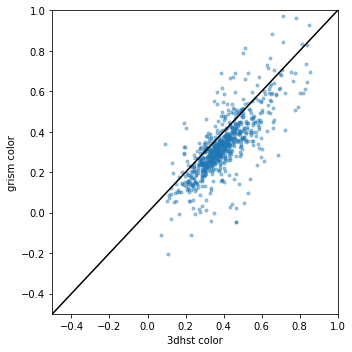

0.06121339829593744


In [10]:
from interpolate_color import mag,color,interpolate_color
import warnings
warnings.filterwarnings('ignore')

mass_cut = 10
apcorr = grism_matched23dhst['flux_auto']/grism_matched23dhst['flux_aper_1']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# HERE DO IT FOR F140W

select = np.isfinite(23.9 - 2.5*np.log10(grism_matched23dhst['f160w_flux_aper_1']*apcorr)) # FLUX MUST BE FINITE
select &= np.isfinite(mag(hst_matched2grism['f_F160W'])) # FLUX MUST BE FINITE
select &= mag(hst_matched2grism['f_F160W'])<24 # MAG MUST BE LESS THAN 24

plt.scatter(mag(hst_matched2grism['f_F160W']),23.9 - 2.5*np.log10(grism_matched23dhst['f160w_flux_aper_1']*apcorr),marker='.',alpha=0.4)
plt.xlabel('3dhst observed F160W mag')
plt.ylabel('3dhst phot F160W mag')
plt.ylim([19,24])
plt.xlim([19,24])
plt.plot([19,24],[19,24],c='k')
plt.show()

# USE THIS F160W OFFSET
offsetf160 = np.median(mag(hst_matched2grism['f_F160W'][select])-(23.9 - 2.5*np.log10(grism_matched23dhst['f160w_flux_aper_1'][select]*apcorr[select])))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# HERE DO IT FOR F160W
select = np.isfinite(23.9 - 2.5*np.log10(grism_matched23dhst['f140w_flux_aper_1']*apcorr))
select &= np.isfinite(mag(hst_matched2grism['f_F140W']))
select &= mag(hst_matched2grism['f_F140W'])<24
select &= hst_matched2grism['lmass'] > mass_cut


plt.scatter(mag(hst_matched2grism['f_F140W'][select]),23.9 - 2.5*np.log10(grism_matched23dhst['f140w_flux_aper_1'][select]*apcorr[select]),marker='.',alpha=0.4)
plt.xlabel('3dhst observed F140W mag')
plt.ylabel('3dhst phot F140W mag')
plt.ylim([18,24])
plt.xlim([18,24])
plt.plot([18,24],[18,24],c='k')
plt.show()

# USE THIS F140W OFFSET
offsetf140 = np.median(mag(hst_matched2grism['f_F140W'][select])-(23.9 - 2.5*np.log10(grism_matched23dhst['f140w_flux_aper_1'][select]*apcorr[select])))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Here find color correction
fig = plt.figure(figsize=(5,5))
ax2 = fig.add_subplot(111)
plt.scatter(color(hst_matched2grism[select]['f_F125W'],hst_matched2grism[select]['f_F160W']),grism_matched23dhst['mag_wfc3,ir,f125w'][select]-grism_matched23dhst['mag_wfc3,ir,f160w'][select],marker='.',alpha=0.4)
ax2.set_ylim([-0.5,1])
ax2.set_xlim([-0.5,1])
ax2.plot([-0.5,1],[-0.5,1],c='k')
ax2.set_ylabel('grism color')
ax2.set_xlabel('3dhst color')
offset_color = np.median(color(hst_matched2grism['f_F125W'][select],hst_matched2grism['f_F160W'][select])-(grism_matched23dhst['mag_wfc3,ir,f125w'][select]-grism_matched23dhst['mag_wfc3,ir,f160w'][select]))
plt.tight_layout()
plt.show()

# USE THIS COLOR OFFSET
print(offset_color)

## Next: Remove objects with extreme colors

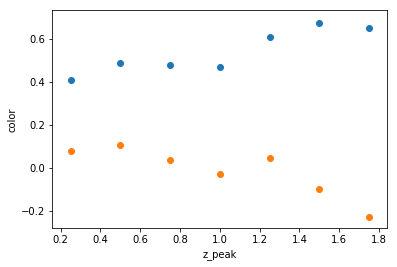

original grism length:  29047
This gets rid of:  8935 galaxies
So now we have:  20112


In [11]:
bins,color_up,color_low = interpolate_color(cat_3dhst_clean)

color_up_interp_cut = np.interp(grism['redshift'], bins, color_up)
color_low_interp_cut = np.interp(grism['redshift'], bins, color_low)

print('original grism length: ',len(grism))
clip_color = (grism['color']+offset_color > color_low_interp_cut) & (grism['color']+offset_color < color_up_interp_cut)

print('This gets rid of: ',len(grism)-clip_color.sum(),'galaxies')
print('So now we have: ',clip_color.sum())

## Get the masses and make sample selection 
(mass > 10 & Ha S/n > 5)

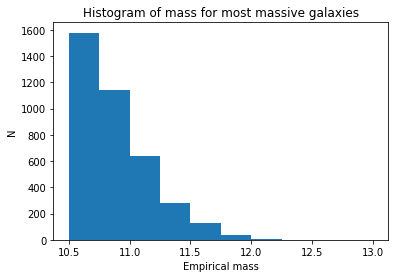

N with M > 10.5: 3820
N with (M > 10.5) and (Ha S/N > 5): 1993
After mass and S/N cut, objects with phot flag:  688


In [15]:
# How I grab the masses
grism_clean = grism[clip_color]
apcorr = grism_clean['flux_auto']/grism_clean['flux_aper_1']

mass = np.zeros(len(grism_clean))
grism_clean_col = np.zeros(len(grism_clean))
hmag_aliza = np.zeros(len(grism_clean))
hmag_filt = np.zeros(len(grism_clean)).astype('str')
flux = np.zeros(len(grism_clean))

f = np.load('../model_uvista_interp/3dhst_mass_f_F140W_f_F125W-f_F160W_d755_z1.0.npy')
g = np.load('../model_uvista_interp/3dhst_mass_f_F160W_f_F125W-f_F160W_d755_z1.0.npy')

def get_mass(redshift, hmag, red, blue, static_fit):
    
    phot_color = blue - red + offset_color
    
    # Input data / output vector
    z = np.maximum(redshift, 0)

    Xfull = np.vstack([np.log(1+z), hmag, phot_color]).T

    clf, poly, use_powers = static_fit

    X_ = poly.fit_transform(Xfull)
    
    y_pred = clf.predict(X_[:,use_powers])
    
    return y_pred

for i in range(len(grism_clean)):
    if (grism_clean['f140w_flux_aper_1'][i] > 0) & np.isfinite(grism_clean['f140w_flux_aper_1'][i]):
        load = f
        hmag = 23.9-2.5*np.log10(grism_clean['f140w_flux_aper_1'][i]*apcorr[i]) + offsetf140
        hmag_aliza[i] = hmag - offsetf140  ## THIS IS THE OFFSET CALCULATED BEFORE
        hmag_filt[i] = 'F140W'
        flux[i] = grism_clean['f140w_flux_aper_1'][i]*apcorr[i]
    elif (grism_clean['f160w_flux_aper_1'][i] > 0) & np.isfinite(grism_clean['f160w_flux_aper_1'][i]):
        load = g
        hmag = 23.9-2.5*np.log10(grism_clean['f160w_flux_aper_1'][i]*apcorr[i]) + offsetf160
        hmag_aliza[i] = hmag - offsetf160 ## THIS IS THE OFFSET CALCULATED BEFORE
        hmag_filt[i] = 'F160W'
        flux[i] = grism_clean['f160w_flux_aper_1'][i]*apcorr[i]
    else:
        mass[i] = -99
        hmag_aliza[i] = 100
        hmag_filt[i] = 'Nope'
        continue
    red = grism_clean['mag_wfc3,ir,f160w'][i]
    blue = grism_clean['mag_wfc3,ir,f125w'][i]
    grism_clean_col[i] = blue - red
    try:
        mass[i] = get_mass(redshift = grism_clean['redshift'][i], hmag = hmag, red = red, blue = blue, static_fit=load)
    except:
        mass[i] = -99

grism_clean['mass'] = mass
grism_clean['hmag_aliza'] = hmag_aliza
grism_clean['grism_clean_col'] = grism_clean_col
grism_clean['hmag_filt'] = hmag_filt
grism_clean['flux'] = flux

plt.hist(grism_clean['mass'],range=[10.5,13])
plt.title('Histogram of mass for most massive galaxies')
plt.xlabel('Empirical mass')
plt.ylabel('N')
plt.show()


# Make cut on mass and Ha S/N
sample = (grism_clean['mass'] > 10.5); print(r'N with M > 10.5:',sample.sum())
sample &= (grism_clean['flux_Ha']/grism_clean['err_Ha'] > 5) ; print(r'N with (M > 10.5) and (Ha S/N > 5):' ,sample.sum())
flag = sample & (grism_clean['flag'] & 1).astype('bool')
print('After mass and S/N cut, objects with phot flag: ',flag.sum())
samp = grism_clean[sample]

## Take a look at all of the galaxies and rate them

In [16]:
full_file,line_file,stack_file = [],[],[]

for i,table in enumerate(samp):
    if table['root'][7] =='+':
        sign = '%2B'
    else:
        sign = '-'
    full_file.append('https://s3.amazonaws.com/aws-grivam/Pipeline/{0}{1}{2}/Extractions/{0}{1}{2}_{3:05d}.full.png'.format(table['root'][:7],
                                                                                                              sign,table['root'][8:],table['id']))
    line_file.append('https://s3.amazonaws.com/aws-grivam/Pipeline/{0}{1}{2}/Extractions/{0}{1}{2}_{3:05d}.line.png'.format(table['root'][:7],
                                                                                                              sign,table['root'][8:],table['id']))
    stack_file.append('https://s3.amazonaws.com/aws-grivam/Pipeline/{0}{1}{2}/Extractions/{0}{1}{2}_{3:05d}.stack.png'.format(table['root'][:7],
                                                                                                sign,table['root'][8:],table['id']))
full_url = ['<a href={0}><img src={0} height=200px></a>'.format(file) for file in full_file]
line_url = ['<a href={0}><img src={0} height=200px></a>'.format(file) for file in line_file]
stack_url = ['<a href={0}><img src={0} height=200px></a>'.format(file) for file in stack_file]

# reformat strings

samp['redshift'].format = '.1f'
samp['mass'].format = '.1f'
samp['flag'].format = '.1f' 

samp['full_png'] = full_url
samp['line_png'] = line_url
samp['stack_png'] = stack_url


cut_tab = samp['root','id','mass','redshift','flag','cat','stack_png','full_png','line_png']

cut_tab.write_sortable_html('check_out_samp.html', max_lines=10000, 
                            filter_columns=['id','mass'])

!open check_out_samp.html

## Apply rating and remove bad objects
I put the ratings in rate.npy

In [24]:
rate = np.load('rate.npy')
clean_samp = samp[rate==0]
#samp[rate==0].write('../final_data/clean_sample.fits',overwrite=True)

print('After applying ratings:')
print('Before: ',len(samp))
print('After:  ',len(samp[rate==0]))
print('\nWISP:   ',np.sum(clean_samp['cat']=='wisp'))
print('3D-HST: ',np.sum((clean_samp['cat']=='3dhst') | (clean_samp['cat']=='other')))

After applying ratings:
Before:  1993
After:   1007

WISP:    557
3D-HST:  450
